In [2]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2


In [52]:
import os
import logging 
import joblib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
from scipy.interpolate import interp1d
from scipy.stats import zscore
from scipy.integrate import trapz
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

import algo_ecg.data
import algo_ecg.preprocessing
#import algo_ecg.model
from algo_ecg.feature_transformer import calculate_hrv_based_on_peak_intervals, \
calculate_hrv_based_on_peak_intervals3, generate_time_fre_domain_features, \
FindPeaksCustomTransformer, select_cols, AllFeatureCustomTransformer

import algo_ecg.feature_transformer

from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from PIL import Image
from IPython.display import display

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['figure.figsize'] = [12, 8]

# Feature engineering

In [43]:
# Read in the data 
X_in, y, pids = algo_ecg.data.import_physionet_data('../data', num_files_to_read=100)
#X_in, y = algo_ecg.data.import_physionet_data('../data')

In [44]:
X_in

array([[-127, -162, -197, ...,  -18,  -22,  -21],
       [ 128,  157,  189, ...,    0,    1,    2],
       [  56,   73,   85, ...,   13,   14,   15],
       ...,
       [   1,    0,    0, ..., -107, -106, -104],
       [ -69,  -93, -110, ...,  -40,  -23,   -6],
       [-232, -272, -312, ..., -129, -107,  -85]], dtype=int16)

In [45]:
X_in.shape

(72, 9000)

In [46]:
X = algo_ecg.preprocessing.preprocess(X_in)

DEBUG:root:
DEBUG:root:i=0: 37 outliers found
DEBUG:root:
DEBUG:root:i=1: 48 outliers found
DEBUG:root:
DEBUG:root:i=2: 6 outliers found
DEBUG:root:i=2: flipped values
DEBUG:root:
DEBUG:root:i=3: 45 outliers found
DEBUG:root:i=3: flipped values
DEBUG:root:
DEBUG:root:i=4: 99 outliers found
DEBUG:root:
DEBUG:root:i=5: 18 outliers found
DEBUG:root:
DEBUG:root:i=6: 44 outliers found
DEBUG:root:
DEBUG:root:i=7: 28 outliers found
DEBUG:root:
DEBUG:root:i=8: 53 outliers found
DEBUG:root:i=8: flipped values
DEBUG:root:
DEBUG:root:i=9: 19 outliers found
DEBUG:root:
DEBUG:root:i=10: 39 outliers found
DEBUG:root:
DEBUG:root:i=11: 119 outliers found
DEBUG:root:
DEBUG:root:i=13: 101 outliers found
DEBUG:root:
DEBUG:root:i=14: 92 outliers found
DEBUG:root:i=14: flipped values
DEBUG:root:
DEBUG:root:i=15: 61 outliers found
DEBUG:root:
DEBUG:root:i=16: 92 outliers found
DEBUG:root:
DEBUG:root:i=17: 13 outliers found
DEBUG:root:
DEBUG:root:i=18: 22 outliers found
DEBUG:root:
DEBUG:root:i=19: 99 outlie

In [47]:
# linear spaced vector between 0.5 pi and 1.5 pi 
v = np.linspace(0.5 * np.pi, 1.5 * np.pi, 15)

# create sine filter for approximating QRS feature
peak_filter = np.sin(v)

# compute cross correlation between ecg and the sine filter
ecg_transformed = np.correlate(X[10], peak_filter, mode="same")


In [49]:
len(ecg_transformed)

9000

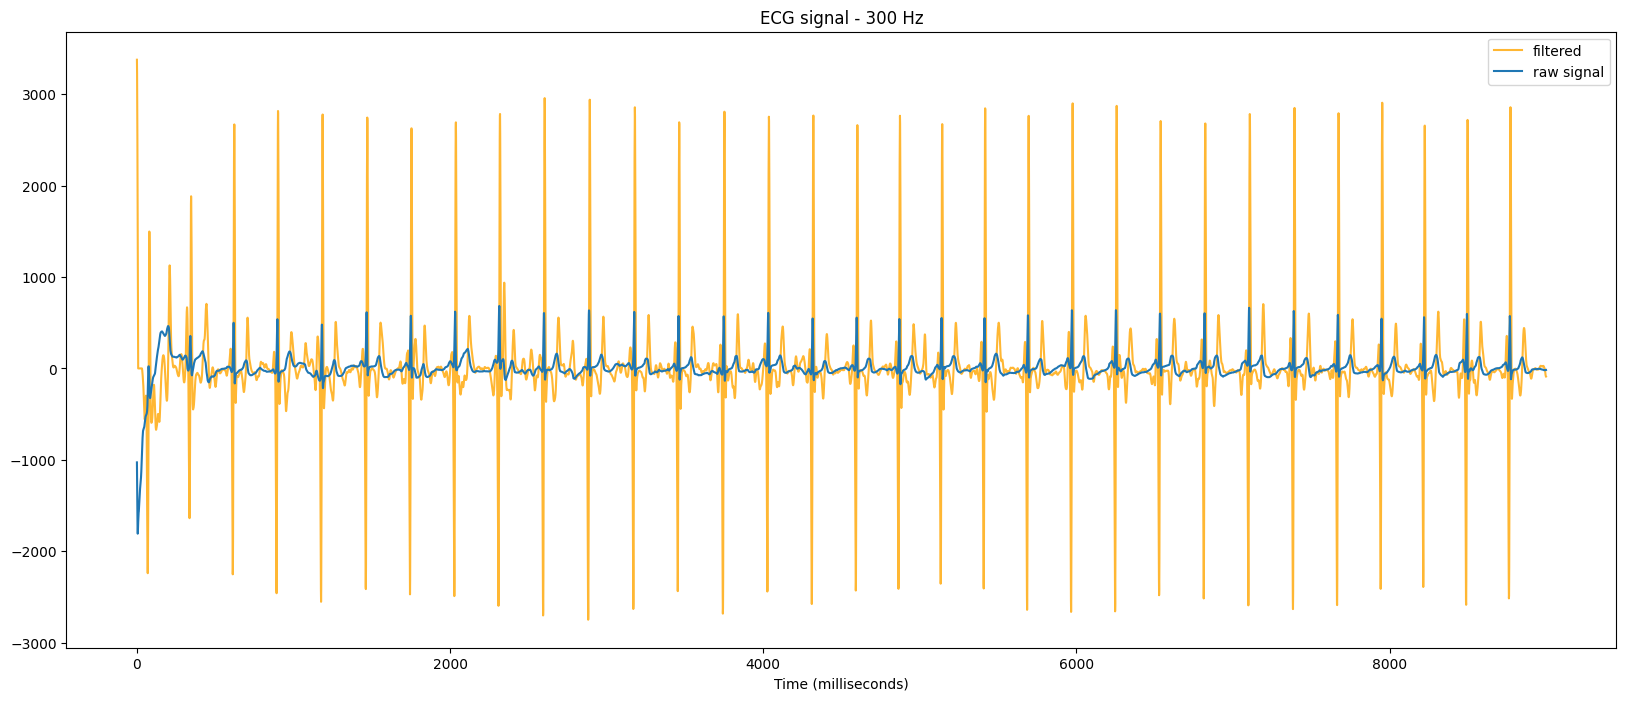

In [50]:
# and plot the raw + filtered signal
plt.figure(figsize=(20,8))
plt.title('ECG signal - 300 Hz')
plt.plot(ecg_transformed[0:9000], alpha = 0.8, c='orange')
plt.plot(X_in[10], alpha = 1)
plt.gca().legend(('filtered','raw signal'))
plt.xlabel('Time (milliseconds)')
plt.show()

The filtered signal (blue) is the computed cross-correlation between the raw signal (orange) and the sinewave filter. This is often referred to as a convolution. You can think of this as a measure of similarity between two signals. In our plot, we easily observe distinct peaks since the R-wave feature is prominent and easily separable—for robust detection of more intricate features, especially those buried under background noise, we would likely require a more complex and specific transform algorithm

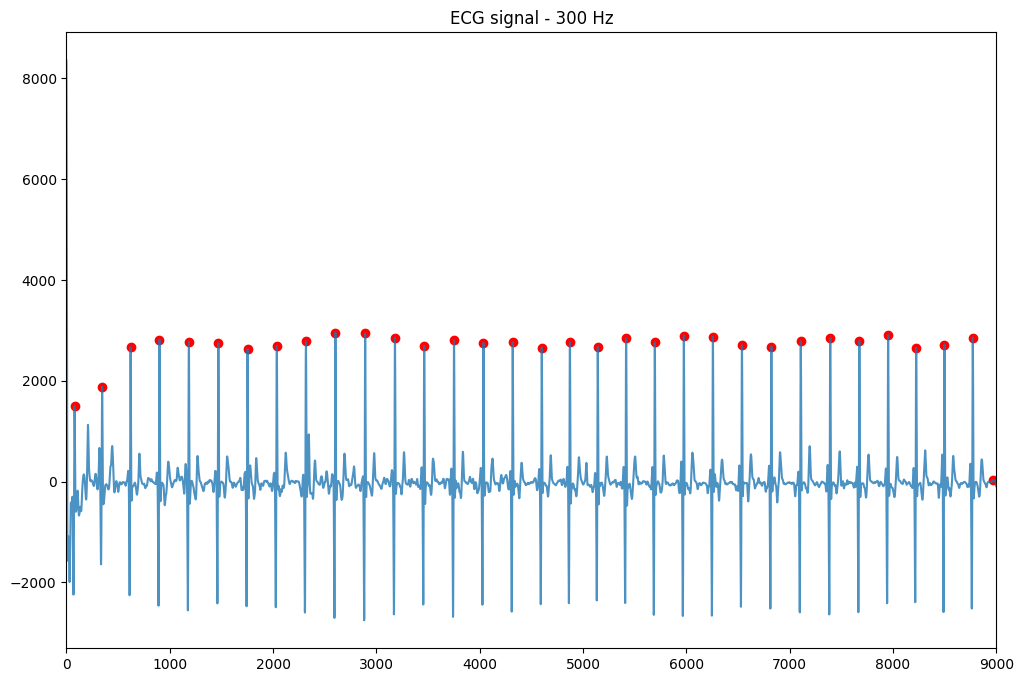

In [22]:
#Peak detection

rr_peaks, _ = find_peaks(ecg_transformed, distance=300*(30/60))
plt.plot(ecg_transformed, alpha = 0.8)
plt.scatter(rr_peaks, ecg_transformed[rr_peaks], color='red')
plt.xlim(0,9000)
plt.title("ECG signal - 300 Hz")
plt.show()


In [23]:
rr_peaks

array([  79,  346,  622,  901, 1186, 1471, 1754, 2037, 2319, 2604, 2892,
       3180, 3463, 3752, 4036, 4320, 4601, 4873, 5143, 5417, 5695, 5976,
       6257, 6538, 6823, 7107, 7393, 7674, 7953, 8225, 8498, 8772, 8964])

In [24]:
len(rr_peaks)

33

## Time domain features

In [25]:
SAMPLING_RATE = 300

In [26]:
# compute the diff along the time axis to end up with the R-R intervals
rr_ecg = np.diff(rr_peaks)

In [27]:
rr_ecg

array([267, 276, 279, 285, 285, 283, 283, 282, 285, 288, 288, 283, 289,
       284, 284, 281, 272, 270, 274, 278, 281, 281, 281, 285, 284, 286,
       281, 279, 272, 273, 274, 192])

In [28]:
#300 hz * 30 seconds = 9000 data points per 30 seconds 
#18000 is the length of one minutes
18000 / rr_ecg

array([67.41573034, 65.2173913 , 64.51612903, 63.15789474, 63.15789474,
       63.60424028, 63.60424028, 63.82978723, 63.15789474, 62.5       ,
       62.5       , 63.60424028, 62.28373702, 63.38028169, 63.38028169,
       64.0569395 , 66.17647059, 66.66666667, 65.69343066, 64.74820144,
       64.0569395 , 64.0569395 , 64.0569395 , 63.15789474, 63.38028169,
       62.93706294, 64.0569395 , 64.51612903, 66.17647059, 65.93406593,
       65.69343066, 93.75      ])

In [29]:
def timedomain(rr):
    results = {}
    sampling_rate = 300 
    rr_in_ms = (rr / sampling_rate) * 1000 
    
    hr = 60 * sampling_rate /rr
#    mean_hr = 60 * sampling_rate/np.mean(rr)

    # HRV metrics
    results['Mean RR (ms)'] = np.mean(rr_in_ms)
    results['STD RR/SDNN (ms)'] = np.std(rr_in_ms)
    results['Mean_HR_beats_per_min_kubio'] = 60 * sampling_rate/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)    
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr_in_ms))))
    results['NN50'] = np.sum(np.abs(np.diff(rr_in_ms)) > 50)*1
    results['pNN50 (%)'] = 100 * np.sum((np.abs(np.diff(rr_in_ms)) > 50)*1) / len(rr_in_ms)
    return results

timedomain(rr_ecg)

{'Mean RR (ms)': 925.5208333333333,
 'STD RR/SDNN (ms)': 54.44549628731675,
 'Mean_HR_beats_per_min_kubio': 64.82836240855374,
 'Mean HR (beats/min)': 65.13826705643545,
 'STD HR (beats/min)': 5.294406940754923,
 'Min HR (beats/min)': 62.28373702422145,
 'Max HR (beats/min)': 93.75,
 'RMSSD (ms)': 50.78240883017448,
 'NN50': 1,
 'pNN50 (%)': 3.125}

In [30]:
algo_ecg.feature_transformer.timedomain(rr_ecg)

{'Mean_RR_ms': 925.5208333333333,
 'STD_RR_ms': 54.44549628731675,
 'Mean_HR_beats_per_min_kubio': 64.82836240855374,
 'Mean_HR_beats_per_min': 65.13826705643545,
 'STD_HR_beats_per_min': 5.294406940754923,
 'Min_HR_beats_per_min': 62.28373702422145,
 'Max_HR_beats_per_min': 93.75,
 'RMSSD_ms': 50.78240883017448,
 'NN50': 1,
 'pNN50': 3.125,
 'NN70': 1,
 'pNN70': 3.125}

## Frequency domain features

In [31]:
# compute the diff along the time axis to end up with the R-R intervals
rr_ecg = np.diff(rr_peaks)

# fit function to the dataset
x_ecg = np.cumsum(rr_ecg)/300 
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

# sample rate for interpolation
fs = 4
steps = 1 / fs

# sample using the interpolation function
xx_ecg = np.arange(0, np.max(x_ecg), steps)
rr_interpolated_ecg = f_ecg(xx_ecg)


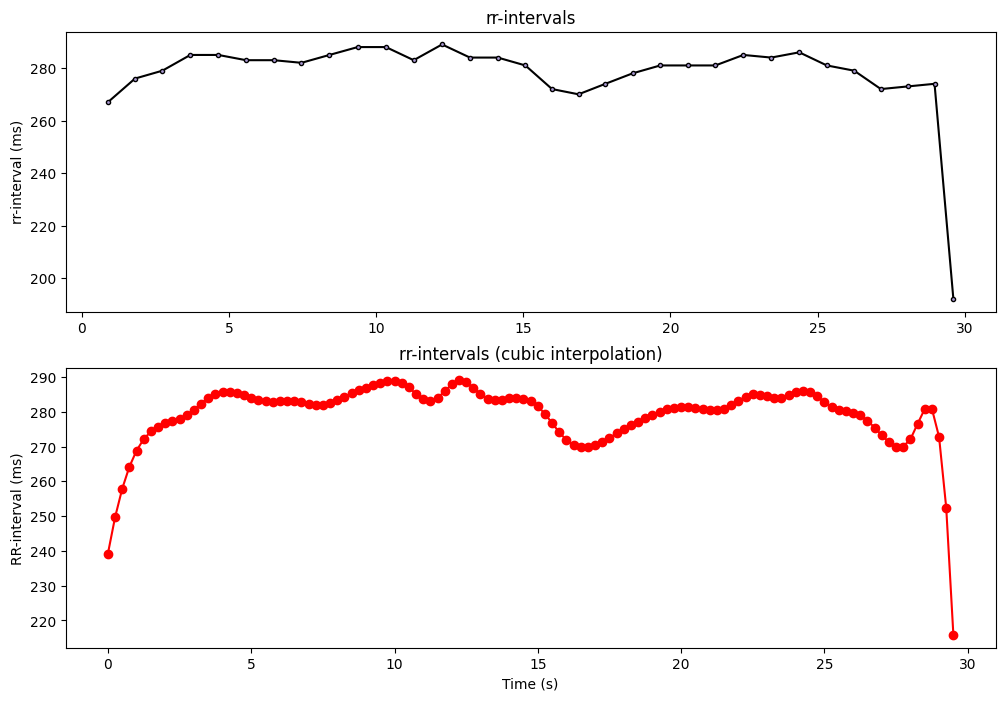

In [32]:
plt.subplot(211)
plt.title('rr-intervals')
plt.plot(x_ecg, rr_ecg, color='k', markerfacecolor='#A999D1',marker='o', markersize=3)
plt.ylabel('rr-interval (ms)')

plt.subplot(212)
plt.title('rr-intervals (cubic interpolation)')
plt.plot(xx_ecg, rr_interpolated_ecg, color='r',marker='o')
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')

plt.show()

In [33]:
# CLeaning & filtering
rr_ecg[np.abs(zscore(rr_ecg)) > 2] = np.median(rr_ecg)
x_ecg = np.cumsum(rr_ecg)/300
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic', fill_value= 'extrapolate')

xx_ecg = np.arange(0, np.max(x_ecg), steps)
clean_rr_interpolated_ecg = f_ecg(xx_ecg)


In [34]:
len(rr_ecg)
rr_ecg[:5]

array([267, 276, 279, 285, 285])

In [35]:
len(rr_ecg)
rr_ecg[:5]

array([267, 276, 279, 285, 285])

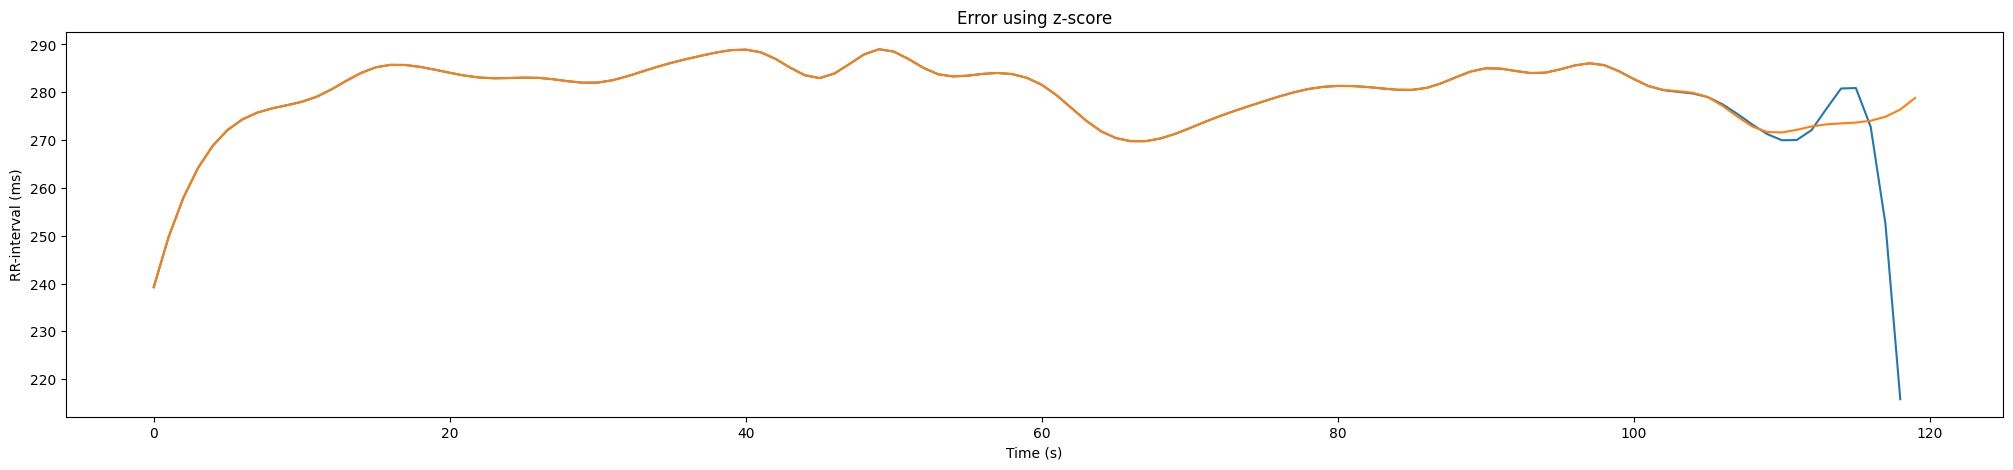

In [36]:
plt.figure(figsize=(25,5))
plt.title('Error using z-score')
plt.plot(rr_interpolated_ecg)
plt.plot(clean_rr_interpolated_ecg)
plt.xlabel('Time (s)')
plt.ylabel('RR-interval (ms)')
plt.show()

In [37]:
rr_interpolated_ecg
len(rr_interpolated_ecg)
#len(clean_rr_interpolated_ecg)

119

In [38]:
fxx, pxx = welch(x=clean_rr_interpolated_ecg, fs=fs, nperseg=len(clean_rr_interpolated_ecg))
powerspectrum_f = interp1d(fxx, pxx, kind='cubic', fill_value= 'extrapolate')

In [39]:
clean_rr_interpolated_ecg

array([239.23093401, 249.67969836, 257.91186727, 264.21106041,
       268.86089742, 272.14499797, 274.34698172, 275.75046831,
       276.63907742, 277.29642869, 278.00614178, 279.05182951,
       280.59693476, 282.3784858 , 284.0389725 , 285.22210257,
       285.73468072, 285.70910799, 285.31645802, 284.72693786,
       284.08384437, 283.49899951, 283.08243869, 282.93049263,
       282.98017507, 283.06571458, 283.01962667, 282.72108133,
       282.30678523, 282.00182321, 282.03120229, 282.52398618,
       283.35048049, 284.33780556, 285.31430459, 286.18169495,
       286.95542387, 287.66072182, 288.31740898, 288.81688523,
       288.91987719, 288.38125054, 287.00196239, 285.14556323,
       283.55170202, 282.9669135 , 283.94358941, 285.91770817,
       287.92697064, 289.0085909 , 288.51402969, 286.95516828,
       285.11167989, 283.76054025, 283.31747424, 283.47702884,
       283.84809331, 284.04394714, 283.80496096, 283.01506076,
       281.56587084, 279.38256538, 276.72871854, 274.06

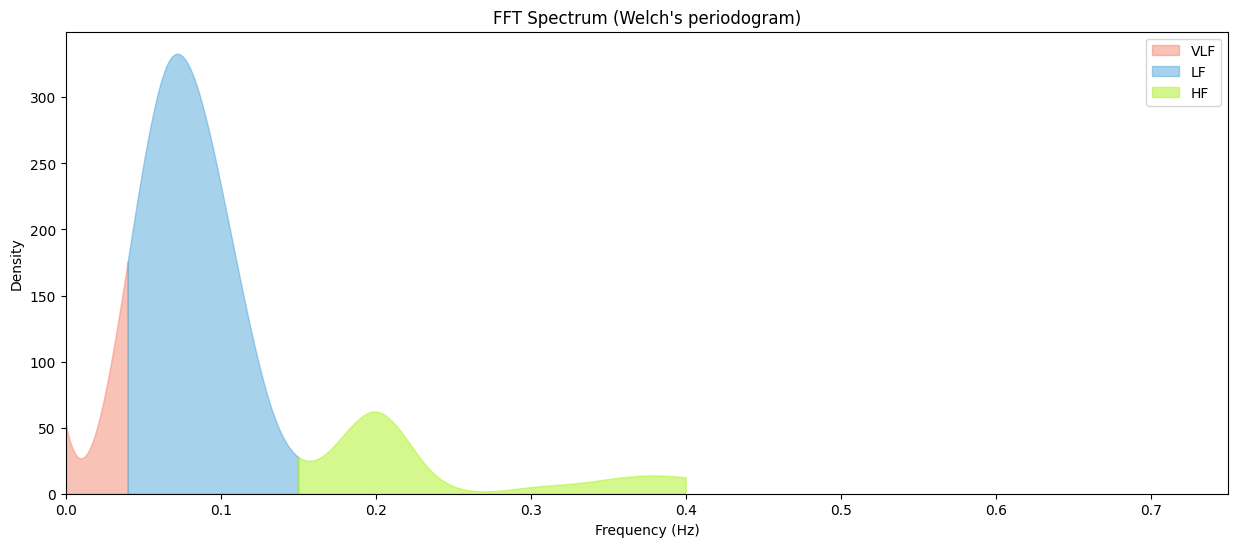

In [40]:
plt.figure(figsize=(15,6))
plt.title("FFT Spectrum (Welch's periodogram)")

# setup frequency bands for plotting
x_VLF = np.linspace(0, 0.04, 100)
x_LF = np.linspace(0.04, 0.15, 100)
x_HF = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_VLF, powerspectrum_f(x_VLF), alpha=0.5, color="#F5866F", label="VLF")
plt.gca().fill_between(x_LF, powerspectrum_f(x_LF), alpha=0.5, color="#51A6D8", label="LF")
plt.gca().fill_between(x_HF, powerspectrum_f(x_HF), alpha=0.5, color="#ABF31F", label="HF")

plt.gca().set_xlim(0, 0.75)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")

plt.legend()
plt.show()

In [41]:
def freq_domain(fxx, pxx):

    #frequency bands: very low frequency (VLF), low frequency (LF), high frequency (HF) 
    cond_VLF = (fxx >= 0) & (fxx < 0.04)
    cond_LF = (fxx >= 0.04) & (fxx < 0.15)
    cond_HF = (fxx >= 0.15) & (fxx < 0.4)

    #calculate power in each band by integrating the spectral density using trapezoidal rule 
    VLF = trapz(pxx[cond_VLF], fxx[cond_VLF])
    LF = trapz(pxx[cond_LF], fxx[cond_LF])
    HF = trapz(pxx[cond_HF], fxx[cond_HF])

    #total power sum
    total_power = VLF + LF + HF

    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_VLF], fxx[cond_VLF])
    lf = trapz(pxx[cond_LF], fxx[cond_LF])
    hf = trapz(pxx[cond_HF], fxx[cond_HF])


    #peaks (Hz) in each band
    peak_VLF = fxx[cond_VLF][np.argmax(pxx[cond_VLF])]
    peak_LF = fxx[cond_LF][np.argmax(pxx[cond_LF])]
    peak_HF = fxx[cond_HF][np.argmax(pxx[cond_HF])]

    #fractions
    LF_nu = 100 * lf / (lf + hf)
    HF_nu = 100 * hf / (lf + hf)

    results = {}
    results['Power VLF (ms2)'] = VLF
    results['Power LF (ms2)'] = LF
    results['Power HF (ms2)'] = HF   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (LF/HF)
    results['Peak VLF (Hz)'] = peak_VLF
    results['Peak LF (Hz)'] = peak_LF
    results['Peak HF (Hz)'] = peak_HF

    results['Fraction LF (nu)'] = LF_nu
    results['Fraction HF (nu)'] = HF_nu

    return results


In [42]:
freq_domain(fxx, pxx)

{'Power VLF (ms2)': 2.994104076912021,
 'Power LF (ms2)': 14.310106367252544,
 'Power HF (ms2)': 3.9740207098192073,
 'Power Total (ms2)': 21.27823115398377,
 'LF/HF': 3.6009138885196106,
 'Peak VLF (Hz)': 0.03333333333333333,
 'Peak LF (Hz)': 0.06666666666666667,
 'Peak HF (Hz)': 0.2,
 'Fraction LF (nu)': 78.26518765119162,
 'Fraction HF (nu)': 21.734812348808376}

### Power Spectral Density (PSD) estimation on RR interval data in the context of heart rate variability (HRV) analysis. 

HRV refers to the variation in time between consecutive heartbeats, and RR intervals (the time between successive R-peaks in the electrocardiogram, ECG) are commonly used for HRV analysis.

PSD analysis provides insights into the frequency distribution of variability within the RR interval time series. The frequency components observed in the PSD of HRV can be associated with different physiological mechanisms, including the influence of the autonomic nervous system on heart rate.

Key frequency bands often analyzed in the context of HRV include:

Very Low-Frequency (VLF): Frequencies below 0.04 Hz. These are associated with long-term regulation mechanisms and are influenced by factors such as circadian rhythms.

Low-Frequency (LF): Frequencies between 0.04 Hz and 0.15 Hz. LF is often associated with sympathetic and parasympathetic interactions.

High-Frequency (HF): Frequencies between 0.15 Hz and 0.4 Hz. HF is mainly influenced by parasympathetic activity and respiratory patterns.

Ultra-Low-Frequency (ULF): Frequencies below 0.0033 Hz. ULF may be associated with even longer-term regulatory mechanisms.

Analyzing the PSD of RR intervals can provide valuable information about the autonomic nervous system's influence on heart rate dynamics. The balance between sympathetic and parasympathetic activity can be inferred from the distribution of power within these frequency bands.

Commonly used methods for PSD estimation in HRV analysis include the Fast Fourier Transform (FFT) and autoregressive (AR) modeling. These techniques help quantify the power in different frequency bands, and changes in the PSD can be associated with various physiological or pathological conditions.

In summary, PSD analysis of RR interval data is a standard approach in HRV research, and it helps researchers and clinicians understand the autonomic regulation of the heart and can be used for various applications, including assessing cardiac health, stress levels, and risk of arrhythmias.